## Reinforcement Learning

In [1]:
import os
import math
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import random
import scipy.stats as stats
import numpy as np
import pandas as pd
import pandas_ta as ta
import seaborn as sns
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
import optuna
from pylab import plt, mpl
import yfinance as yf
import stable_baselines3
from stable_baselines3.common.callbacks import EvalCallback
import gym
import tensorflow as tf
plt.style.use('seaborn-v0_8')
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['figure.figsize'] = (10, 10) 
mpl.rcParams['font.family'] = 'serif'
np.set_printoptions(precision=4, suppress=True)
os.environ['PYTHONHASHSEED'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
random.seed(100)
np.random.seed(100)
tf.random.set_seed(100)
np.random.seed(100)

In [3]:
# Retrieve historical Bitcoin data
symbol = 'BTC-USD'
yahoo_info = yf.Ticker(symbol)
df = yahoo_info.history(period="84mo")
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2016-12-03,778.247986,778.247986,764.856018,771.155029,69547296,0,0
2016-12-04,771.638000,773.872009,768.161011,773.872009,60557900,0,0
2016-12-05,773.393982,773.468018,751.713013,758.700012,106363000,0,0
2016-12-06,758.719971,765.622009,758.719971,764.223999,116218000,0,0
2016-12-07,764.210999,771.543030,759.750000,768.132019,96426096,0,0
...,...,...,...,...,...,...,...
2023-11-29,37826.105469,38366.113281,37612.632812,37858.492188,20728546658,0,0
2023-11-30,37861.117188,38141.753906,37531.140625,37712.746094,18115982627,0,0
2023-12-01,37718.007812,38954.109375,37629.359375,38688.750000,23512784002,0,0


In [4]:
# Apply technical analysis indicators to the DataFrame 
df = df.ta.ticker(symbol)

In [5]:
# Calculate returns
df['Returns'] = np.log(df['Close']).diff()
df['Ret_1M'] = df['Returns'].rolling(20).sum()

# Output first five values
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Returns,Ret_1M
Date,,,,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,0,0,NaN,NaN
2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,0,0,-0.074643,NaN
2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,0,0,-0.072402,NaN
2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,0,0,0.035111,NaN
2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,0,0,-0.024968,NaN


In [6]:
# Define a custom trading strategy 
CustomStrategy = ta.Strategy(
    name="Momentum and Volatility",  
    description="SMA 50,200, BBANDS, RSI, MACD and Volume SMA 20",  

    # List of technical indicators to be applied to the DataFrame
    ta=[
        {"kind": "sma", "length": 50},  # Simple Moving Average with a period of 50
        {"kind": "sma", "length": 200},  # Simple Moving Average with a period of 200
        {"kind": "bbands", "length": 20},  # Bollinger Bands with a period of 20
        {"kind": "rsi"},  # Relative Strength Index (RSI)
        {"kind": "macd", "fast": 8, "slow": 21},  # Moving Average Convergence Divergence (MACD)
        {"kind": "sma", "close": "volume", "length": 20, "prefix": "VOLUME"},  # Volume-based Simple Moving Average with a period of 20
    ]
)

# Run the strategy on the DataFrame
df.ta.strategy(CustomStrategy)  
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Returns,Ret_1M,SMA_50,...,BBL_20_2.0,BBM_20_2.0,BBU_20_2.0,BBB_20_2.0,BBP_20_2.0,RSI_14,MACD_8_21_9,MACDh_8_21_9,MACDs_8_21_9,VOLUME_SMA_20
Date,,,,,,,,,,,,,,,,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,0,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,0,0,-0.074643,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,0,0,-0.072402,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,0,0,0.035111,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,0,0,-0.024968,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-29,37826.105469,38366.113281,37612.632812,37858.492188,20728546658,0,0,0.000724,0.031266,34112.398086,...,35760.558406,37105.174609,38449.790813,7.247594,0.780124,61.115245,737.630961,-111.080766,848.711727,1.917921e+10
2023-11-30,37861.117188,38141.753906,37531.140625,37712.746094,18115982627,0,0,-0.003857,0.010630,34329.186602,...,35757.081268,37125.113477,38493.145685,7.369848,0.714773,59.858277,696.893173,-121.454843,818.348017,1.894944e+10
2023-12-01,37718.007812,38954.109375,37629.359375,38688.750000,23512784002,0,0,0.025551,0.040907,34567.825625,...,35674.111947,37202.648438,38731.184928,8.217353,0.986119,65.043235,782.172156,-28.940688,811.112844,1.942887e+10


In [7]:
features_list = []
for r in range(10, 65, 5):
    df['Ret_'+str(r)] = df.Returns.rolling(r).sum()
    df['Std_'+str(r)] = df.Returns.rolling(r).std()
    features_list.append('Ret_'+str(r))
    features_list.append('Std_'+str(r))

# Drop columns from dataframe
df.drop(['Dividends','Stock Splits'], axis=1, inplace=True)    

# Drop NaN values
df.dropna(inplace=True)

Text(0.5, 1.0, 'Features Set Correlations')

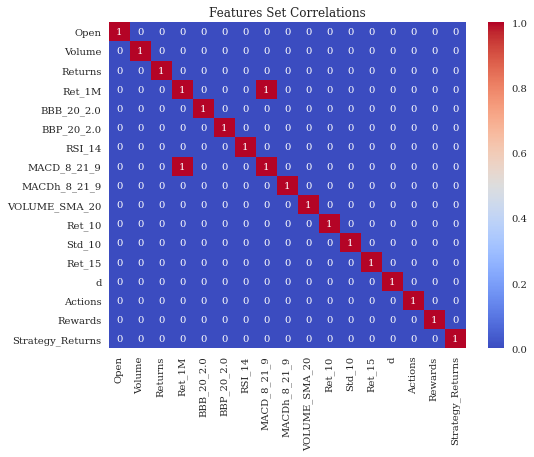

In [27]:
# Check correlated features
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr()>0.9,
annot=True,
cmap="coolwarm",
cbar=True); 
plt.title('Features Set Correlations')

In [9]:
# Remove the first feature that is correlated with any other feature
def correlated_features(data, threshold=0.9):
    col_corr = set()
    corr_matrix = df.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr

In [10]:
# Total correlated features
drop_correlated_features = correlated_features(df)

# Drop the highly correlated features
X = df.drop(drop_correlated_features, axis=1)

# Record feature names
feature_names = X.columns

X['d'] = (X['Returns'] > 0).astype(int)

X

,Open,Volume,Returns,Ret_1M,BBB_20_2.0,BBP_20_2.0,RSI_14,MACD_8_21_9,MACDh_8_21_9,VOLUME_SMA_20,Ret_10,Std_10,Ret_15,d
Date,,,,,,,,,,,,,,
2015-04-04,254.291000,12493500,-0.002461,-0.121224,19.783932,0.442125,47.508324,-4.456203,1.282742,2.583737e+07,0.030009,0.019732,-0.031245,0
2015-04-05,253.761002,19649200,0.026838,-0.108945,15.833630,0.635214,52.432292,-2.852673,2.309017,2.574402e+07,0.047407,0.021084,0.002201,1
2015-04-06,260.721008,20034200,-0.019788,-0.111068,11.549890,0.563389,48.785829,-2.331718,2.263978,2.567088e+07,0.033685,0.022278,-0.047647,0
2015-04-07,255.274002,18467400,-0.009090,-0.012244,11.517194,0.489754,47.185618,-2.219858,1.900670,2.374384e+07,0.001510,0.021421,-0.052174,0
2015-04-08,253.063995,30086400,-0.032753,-0.062897,11.571791,0.237969,41.956153,-3.167171,0.762686,2.261156e+07,0.009468,0.019822,-0.002336,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-29,37826.105469,20728546658,0.000724,0.031266,7.247594,0.780124,61.115245,737.630961,-111.080766,1.917921e+10,0.012544,0.022358,0.063263,1
2023-11-30,37861.117188,18115982627,-0.003857,0.010630,7.369848,0.714773,59.858277,696.893173,-121.454843,1.894944e+10,0.006272,0.022410,-0.004441,0
2023-12-01,37718.007812,23512784002,0.025551,0.040907,8.217353,0.986119,65.043235,782.172156,-28.940688,1.942887e+10,0.077215,0.016733,0.067740,1


In [11]:
class Finance(gym.Env):
    def __init__(self, data, features, window, lags,
                 leverage=1, min_performance=0.85,
                 start=0, end=None, mu=None, std=None):
        super(Finance, self).__init__()
        self.features = features
        self.n_features = len(features)
        self.window = window
        self.lags = lags
        self.leverage = leverage
        self.min_performance = min_performance
        self.start = start
        self.end = end
        self.mu = mu
        self.std = std
        self.data = data
        self.episode_performances = []

        # Initialize performance and benchmark_performance attributes
        self.performance = 1
        self.benchmark_performance = 1

        # Define action and observation space
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(self.lags, self.n_features), dtype=np.float32)
        self.action_space = gym.spaces.Discrete(2)

    def _get_state(self):
        return self.data[self.features].iloc[self.bar - self.lags:self.bar]

    def seed(self, seed):
        random.seed(seed)
        np.random.seed(seed)


    def reset(self):
        self.treward = 0
        self.accuracy = 0
        self.performance = 1
        self.bar = self.lags
        state = self.data[self.features].iloc[self.bar-self.lags:self.bar]
        return state.values

    def step(self, action):
        correct = action == self.data['d'].iloc[self.bar]
        ret = self.data['Returns'].iloc[self.bar] * self.leverage

        # Calculate rewards
        reward_1 = 1 if correct else -1
        reward_2 = abs(ret) if correct else -abs(ret)
        reward_3 = 0  

        # Compare agent's return to benchmark return
        benchmark_return = self.data['Returns'].iloc[self.bar]
        excess_return = ret - benchmark_return  # Excess return over benchmark

        # Reward for outperforming the benchmark
        outperformance_reward = excess_return if excess_return > 0 else 0

        # Update metrics
        self.treward += reward_1
        self.bar += 1
        self.accuracy = self.treward / (self.bar - self.lags)
        self.performance *= math.exp(reward_2)

        if self.performance < 0.85:  # drawdown
            reward_3 -= 2  # penalty

        # Dynamically adjust position based on rewards
        custom_metric = reward_1 + reward_2 * 3 + reward_3 + outperformance_reward * 5 
        self.leverage = 1 + custom_metric / (self.bar - self.lags)

        # Define conditions for episode termination
        done = False
        if self.bar >= len(self.data):
            done = True

        # Get the next state
        state = self._get_state()

        # Combine rewards for a total reward signal
        total_reward = reward_1 + reward_2 + reward_3 + outperformance_reward * 5

        info = {
            'Performance': self.performance,
            'Accuracy': self.accuracy,
            'Excess_Return': excess_return,
            'Leverage': self.leverage
        }

        return state.values, total_reward, done, info


In [12]:
features = X.columns.tolist()

a = 0       
b = 2500
c = 638

# Initialize learn_env
learn_env = Finance(data=X.iloc[a:a+b], features=features, window=10, lags=6,
                    leverage=1, min_performance=0.85,
                    start=0, end=None, mu=None, std=None)

# Initialize valid_env
valid_env = Finance(data=X.iloc[a+b:a+b+c], features=features, window=learn_env.window,
                    lags=learn_env.lags, leverage=learn_env.leverage,
                    min_performance=learn_env.min_performance,
                    start=0, end=None, mu=learn_env.mu, std=learn_env.std)


In [13]:
# Check the information 
learn_env.data[learn_env.features].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2500 entries, 2015-04-04 to 2022-02-05
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Open           2500 non-null   float64
 1   Volume         2500 non-null   int64  
 2   Returns        2500 non-null   float64
 3   Ret_1M         2500 non-null   float64
 4   BBB_20_2.0     2500 non-null   float64
 5   BBP_20_2.0     2500 non-null   float64
 6   RSI_14         2500 non-null   float64
 7   MACD_8_21_9    2500 non-null   float64
 8   MACDh_8_21_9   2500 non-null   float64
 9   VOLUME_SMA_20  2500 non-null   float64
 10  Ret_10         2500 non-null   float64
 11  Std_10         2500 non-null   float64
 12  Ret_15         2500 non-null   float64
 13  d              2500 non-null   int64  
dtypes: float64(12), int64(2)
memory usage: 293.0 KB


In [14]:
valid_env.data[valid_env.features].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 638 entries, 2022-02-06 to 2023-11-05
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Open           638 non-null    float64
 1   Volume         638 non-null    int64  
 2   Returns        638 non-null    float64
 3   Ret_1M         638 non-null    float64
 4   BBB_20_2.0     638 non-null    float64
 5   BBP_20_2.0     638 non-null    float64
 6   RSI_14         638 non-null    float64
 7   MACD_8_21_9    638 non-null    float64
 8   MACDh_8_21_9   638 non-null    float64
 9   VOLUME_SMA_20  638 non-null    float64
 10  Ret_10         638 non-null    float64
 11  Std_10         638 non-null    float64
 12  Ret_15         638 non-null    float64
 13  d              638 non-null    int64  
dtypes: float64(12), int64(2)
memory usage: 74.8 KB


In [15]:
#Train the model using PPO
model = PPO("MlpPolicy", learn_env, verbose=1)
model.learn(total_timesteps=100000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 336  |
|    iterations      | 1    |
|    time_elapsed    | 6    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2.49e+03    |
|    ep_rew_mean          | 53.6        |
| time/                   |             |
|    fps                  | 285         |
|    iterations           | 2           |
|    time_elapsed         | 14          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.015128136 |
|    clip_fraction        | 0.121       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.68       |
|    explained_variance   | -0.00955    |
|    learning_rate        | 0.0003      |
|    loss               

In [16]:
import pandas as pd
import numpy as np

def backtest_strategy(env, model):
    obs = env.reset()
    done = False
    actions = []
    rewards_list = []

    while not done:
        action, _states = model.predict(obs)
        actions.append(action)
        obs, reward, done, info = env.step(action)
        rewards_list.append(reward)

    df = env.data.copy()
    df = df.iloc[:len(actions)]
    df['Actions'] = actions
    df['Rewards'] = rewards_list
    df['Strategy_Returns'] = df['Actions'] * df['Returns'].shift(1).fillna(0)
    
    return df

def calculate_metrics(df):
    # Metrics for Strategy
    total_return = (df['Strategy_Returns'].sum() + 1) * 100 - 100  
    max_drawdown = ((df['Strategy_Returns'].cumsum().cummax() - df['Strategy_Returns'].cumsum()).max()) * 100 
    annualized_sharpe_ratio = df['Strategy_Returns'].mean() / df['Strategy_Returns'].std() * np.sqrt(252)
   
    # Metrics for Benchmark
    benchmark_total_return = (df['Returns'].sum() + 1) * 100 - 100  
    benchmark_max_drawdown = ((df['Returns'].cumsum().cummax() - df['Returns'].cumsum()).max()) * 100
    benchmark_annualized_sharpe_ratio = df['Returns'].mean() / df['Returns'].std() * np.sqrt(252)
    
    return (total_return, max_drawdown, annualized_sharpe_ratio), (benchmark_total_return, benchmark_max_drawdown, benchmark_annualized_sharpe_ratio)

# Run backtest_strategy to get df
df = backtest_strategy(valid_env, model)  

# Calculate metrics for strategy and benchmark
strategy_metrics, benchmark_metrics = calculate_metrics(df)


In [17]:
num_trials = 100

# Placeholder for storing metrics from all trials
all_strategy_metrics = []
all_benchmark_metrics = []

for trial in range(num_trials):
    # Backtest the strategy
    df = backtest_strategy(valid_env, model)
    
    # Calculate metrics for strategy and benchmark
    strategy_metrics, benchmark_metrics = calculate_metrics(df)
    
    # Append the metrics to the lists
    all_strategy_metrics.append(strategy_metrics)

# Convert list of metrics to a NumPy array for calculations
all_strategy_metrics = np.array(all_strategy_metrics)

# Calculate mean and standard error for strategy and benchmark
mean_strategy_metrics = np.mean(all_strategy_metrics, axis=0)
std_err_strategy_metrics = np.std(all_strategy_metrics, axis=0)

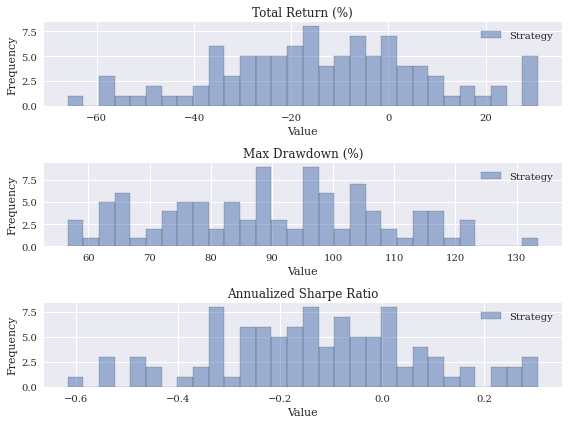

In [18]:
plt.figure(figsize=(8, 6))
for i, metric in enumerate(['Total Return (%)', 'Max Drawdown (%)', 'Annualized Sharpe Ratio']):
    plt.subplot(3,1,i+1)  
    plt.hist(all_strategy_metrics[:, i], bins=30, alpha=0.5, label='Strategy', edgecolor='k')
    plt.title(metric)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend()

plt.tight_layout()
plt.show()

In [19]:
# Calculate mean metrics
mean_strategy_metrics = all_strategy_metrics.mean(axis=0)
mean_benchmark_metrics = benchmark_metrics

# Create a DataFrame to display the metrics
metrics_df = pd.DataFrame(index=['Total Return (%)', 'Max Drawdown (%)', 'Annualized Sharpe Ratio'])
metrics_df['Strategy'] = mean_strategy_metrics
metrics_df['Benchmark'] = benchmark_metrics

# Display the DataFrame
metrics_df

,Strategy,Benchmark
Total Return (%),-13.755594,-18.324687
Max Drawdown (%),89.938768,110.080317
Annualized Sharpe Ratio,-0.128038,-0.158451


In [20]:
def backtest_strategy_ensemble(env, model, num_runs=100):
    df2 = env.data.copy()
    df2['Actions'] = 0
    df2['Rewards'] = 0
    df2['Signals'] = ''
    df2['Position_Size'] = 0
    
    for _ in range(num_runs):
        obs = env.reset()
        done = False
        actions = []
        rewards_list = []
        signals = []
        position_sizes = []

        while not done:
            action, _states = model.predict(obs)
            actions.append(action)
            obs, reward, done, info = env.step(action)
            rewards_list.append(reward)

            # Translate action to trading signal: 
            signal = 'Long' if action == 1 else 'Short'  
            signals.append(signal)

            # The position size is determined by the leverage
            position_size = info['Leverage']
            position_sizes.append(position_size)

        temp_df = df2.iloc[:len(actions)].copy()
        temp_df['Actions'] = actions
        temp_df['Rewards'] = rewards_list
        temp_df['Signals'] = signals
        temp_df['Position_Size'] = position_sizes
        
        df2['Actions'][:len(actions)] += temp_df['Actions']
        df2['Rewards'][:len(actions)] += temp_df['Rewards']
        df2['Signals'][:len(actions)] = temp_df['Signals']  
        df2['Position_Size'][:len(actions)] += temp_df['Position_Size']

    # Average the actions, rewards, and position sizes over the runs
    df2['Actions'] = df2['Actions'] / num_runs
    df2['Rewards'] = df2['Rewards'] / num_runs
    df2['Position_Size'] = df2['Position_Size'] / num_runs
    df2['Strategy_Returns'] = df2['Actions'] * df2['Returns'].shift(1).fillna(0)

    return df2



<ipython-input-20-e18e84ab6612>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Actions'][:len(actions)] += temp_df['Actions']
<ipython-input-20-e18e84ab6612>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Rewards'][:len(actions)] += temp_df['Rewards']
<ipython-input-20-e18e84ab6612>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Signals'][:len(actions)] = temp_df['Signals']
<ipython-input-20-e18e84ab6612>:39: Se

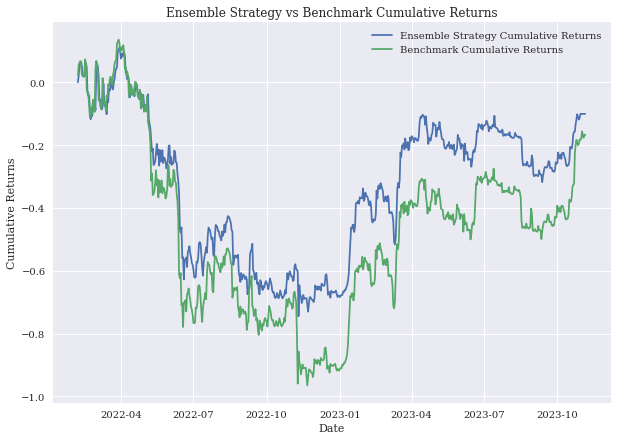

In [21]:
# Backtest the ensemble strategy
results = backtest_strategy_ensemble(valid_env, model)

# Calculate cumulative returns
strategy_cumulative_returns = results['Strategy_Returns'].cumsum()
benchmark_cumulative_returns = results['Returns'].cumsum()

# Plot the results
plt.figure(figsize=(10, 7))
plt.plot(strategy_cumulative_returns, label='Ensemble Strategy Cumulative Returns')
plt.plot(benchmark_cumulative_returns, label='Benchmark Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Ensemble Strategy vs Benchmark Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
def evaluate_model(model, env, num_episodes=10):
    total_rewards = 0.0
    for _ in range(num_episodes):
        obs = env.reset()
        done = False
        while not done:
            action, _states = model.predict(obs)
            obs, rewards, done, info = env.step(action)
            total_rewards += rewards
    average_reward = total_rewards / num_episodes
    return average_reward

def optimize_ppo(trial):
    # Define the environment
    env = learn_env  

    # Hyperparameters to be tuned
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
    gamma = trial.suggest_uniform('gamma', 0.8, 0.9999)
    gae_lambda = trial.suggest_uniform('gae_lambda', 0.8, 0.95)
    
    # Create the model with suggested hyperparameters
    model = PPO("MlpPolicy", env, learning_rate=learning_rate, gamma=gamma, gae_lambda=gae_lambda, verbose=1)

    # Train the model
    model.learn(total_timesteps=10000)

    # Evaluate the model
    average_reward = evaluate_model(model, env)
    return average_reward

# Create the Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(optimize_ppo, n_trials=25)




[I 2023-12-03 12:08:21,718] A new study created in memory with name: no-name-40a65c26-bf49-4c6d-960c-5c2e1d164d24
<ipython-input-22-d54de3055de8>:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
<ipython-input-22-d54de3055de8>:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  gamma = trial.suggest_uniform('gamma', 0.8, 0.9999)
<ipython-input-22-d54de3055de8>:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  ga

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 381  |
|    iterations      | 1    |
|    time_elapsed    | 5    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2.49e+03    |
|    ep_rew_mean          | -3.42e+03   |
| time/                   |             |
|    fps                  | 329         |
|    iterations           | 2           |
|    time_elapsed         | 12          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.015368758 |
|    clip_fraction        | 0.156       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.683      |
|    explained_variance   | -0.0311     |
|    learning_rate        | 0.00782     |
|    loss               

[I 2023-12-03 12:09:54,136] Trial 0 finished with value: -3010.1773241661444 and parameters: {'learning_rate': 0.00782104751128408, 'gamma': 0.979006580025398, 'gae_lambda': 0.8353565400371565}. Best is trial 0 with value: -3010.1773241661444.
<ipython-input-22-d54de3055de8>:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
<ipython-input-22-d54de3055de8>:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  gamma = trial.suggest_uniform('gamma', 0.8, 0.9999)
<ipython-input-22-d54de3055de8>:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be remove

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 378  |
|    iterations      | 1    |
|    time_elapsed    | 5    |
|    total_timesteps | 2048 |
-----------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 2.49e+03      |
|    ep_rew_mean          | -2.84e+03     |
| time/                   |               |
|    fps                  | 336           |
|    iterations           | 2             |
|    time_elapsed         | 12            |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 0.00021372794 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.693        |
|    explained_variance   | -0.00488      |
|    learning_rate        | 5.3e-05 

[I 2023-12-03 12:13:13,570] Trial 1 finished with value: 53.118302254721485 and parameters: {'learning_rate': 5.2984860220405195e-05, 'gamma': 0.8101994839103186, 'gae_lambda': 0.9285339691249318}. Best is trial 1 with value: 53.118302254721485.
<ipython-input-22-d54de3055de8>:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
<ipython-input-22-d54de3055de8>:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  gamma = trial.suggest_uniform('gamma', 0.8, 0.9999)
<ipython-input-22-d54de3055de8>:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be remo

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 401  |
|    iterations      | 1    |
|    time_elapsed    | 5    |
|    total_timesteps | 2048 |
-----------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 2.49e+03   |
|    ep_rew_mean          | -3.5e+03   |
| time/                   |            |
|    fps                  | 345        |
|    iterations           | 2          |
|    time_elapsed         | 11         |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.02802924 |
|    clip_fraction        | 0.24       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.678     |
|    explained_variance   | -0.00956   |
|    learning_rate        | 0.0123     |
|    loss                 | 13.4       |

[I 2023-12-03 12:21:27,628] Trial 2 finished with value: 237.5891770661267 and parameters: {'learning_rate': 0.012308062264158396, 'gamma': 0.906248786272632, 'gae_lambda': 0.9367297634608706}. Best is trial 2 with value: 237.5891770661267.
<ipython-input-22-d54de3055de8>:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
<ipython-input-22-d54de3055de8>:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  gamma = trial.suggest_uniform('gamma', 0.8, 0.9999)
<ipython-input-22-d54de3055de8>:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed i

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 274  |
|    iterations      | 1    |
|    time_elapsed    | 7    |
|    total_timesteps | 2048 |
-----------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 2.49e+03  |
|    ep_rew_mean          | -2.21e+03 |
| time/                   |           |
|    fps                  | 223       |
|    iterations           | 2         |
|    time_elapsed         | 18        |
|    total_timesteps      | 4096      |
| train/                  |           |
|    approx_kl            | 7.2840004 |
|    clip_fraction        | 0.991     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.04     |
|    explained_variance   | -0.00134  |
|    learning_rate        | 0.0574    |
|    loss                 | 15.3      |
|    n_updates  

[I 2023-12-03 12:23:19,513] Trial 3 finished with value: 237.5891770661267 and parameters: {'learning_rate': 0.05743835734162793, 'gamma': 0.8104124413336213, 'gae_lambda': 0.9172413471431867}. Best is trial 2 with value: 237.5891770661267.
<ipython-input-22-d54de3055de8>:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
<ipython-input-22-d54de3055de8>:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  gamma = trial.suggest_uniform('gamma', 0.8, 0.9999)
<ipython-input-22-d54de3055de8>:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed i

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 406  |
|    iterations      | 1    |
|    time_elapsed    | 5    |
|    total_timesteps | 2048 |
-----------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 2.49e+03      |
|    ep_rew_mean          | -988          |
| time/                   |               |
|    fps                  | 351           |
|    iterations           | 2             |
|    time_elapsed         | 11            |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 0.00045972483 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.693        |
|    explained_variance   | 0.00708       |
|    learning_rate        | 2.09e-05

[I 2023-12-03 12:24:45,802] Trial 4 finished with value: -1841.2822580310778 and parameters: {'learning_rate': 2.085040800194069e-05, 'gamma': 0.9978784573579322, 'gae_lambda': 0.9081740742913438}. Best is trial 2 with value: 237.5891770661267.
<ipython-input-22-d54de3055de8>:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
<ipython-input-22-d54de3055de8>:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  gamma = trial.suggest_uniform('gamma', 0.8, 0.9999)
<ipython-input-22-d54de3055de8>:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be remov

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 407  |
|    iterations      | 1    |
|    time_elapsed    | 5    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 2.49e+03     |
|    ep_rew_mean          | -4.77e+03    |
| time/                   |              |
|    fps                  | 355          |
|    iterations           | 2            |
|    time_elapsed         | 11           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0036574048 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.691       |
|    explained_variance   | -0.0172      |
|    learning_rate        | 2.76e-05     |
|    los

[I 2023-12-03 12:26:14,194] Trial 5 finished with value: -936.8891553971255 and parameters: {'learning_rate': 2.755052219205702e-05, 'gamma': 0.9664688664410734, 'gae_lambda': 0.8623531357334796}. Best is trial 2 with value: 237.5891770661267.
<ipython-input-22-d54de3055de8>:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
<ipython-input-22-d54de3055de8>:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  gamma = trial.suggest_uniform('gamma', 0.8, 0.9999)
<ipython-input-22-d54de3055de8>:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be remove

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 340  |
|    iterations      | 1    |
|    time_elapsed    | 6    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2.49e+03    |
|    ep_rew_mean          | -4.78e+03   |
| time/                   |             |
|    fps                  | 325         |
|    iterations           | 2           |
|    time_elapsed         | 12          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.017139778 |
|    clip_fraction        | 0.148       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.679      |
|    explained_variance   | -0.00843    |
|    learning_rate        | 0.000352    |
|    loss               

[I 2023-12-03 12:27:41,645] Trial 6 finished with value: -398.61321668400853 and parameters: {'learning_rate': 0.00035221305158626687, 'gamma': 0.8721818011655229, 'gae_lambda': 0.888437446672242}. Best is trial 2 with value: 237.5891770661267.
<ipython-input-22-d54de3055de8>:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
<ipython-input-22-d54de3055de8>:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  gamma = trial.suggest_uniform('gamma', 0.8, 0.9999)
<ipython-input-22-d54de3055de8>:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be remov

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 391  |
|    iterations      | 1    |
|    time_elapsed    | 5    |
|    total_timesteps | 2048 |
-----------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 2.49e+03   |
|    ep_rew_mean          | -2.89e+03  |
| time/                   |            |
|    fps                  | 349        |
|    iterations           | 2          |
|    time_elapsed         | 11         |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.01291076 |
|    clip_fraction        | 0.244      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.678     |
|    explained_variance   | -0.0044    |
|    learning_rate        | 0.0048     |
|    loss                 | 8.15       |

[I 2023-12-03 12:29:07,327] Trial 7 finished with value: 159.53940831287662 and parameters: {'learning_rate': 0.00480332635445539, 'gamma': 0.8379725642495356, 'gae_lambda': 0.8956971377655014}. Best is trial 2 with value: 237.5891770661267.
<ipython-input-22-d54de3055de8>:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
<ipython-input-22-d54de3055de8>:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  gamma = trial.suggest_uniform('gamma', 0.8, 0.9999)
<ipython-input-22-d54de3055de8>:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed 

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 406  |
|    iterations      | 1    |
|    time_elapsed    | 5    |
|    total_timesteps | 2048 |
-----------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 2.49e+03  |
|    ep_rew_mean          | -2.98e+03 |
| time/                   |           |
|    fps                  | 349       |
|    iterations           | 2         |
|    time_elapsed         | 11        |
|    total_timesteps      | 4096      |
| train/                  |           |
|    approx_kl            | 8.166481  |
|    clip_fraction        | 0.982     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0484   |
|    explained_variance   | 0.000264  |
|    learning_rate        | 0.0553    |
|    loss                 | 6.43      |
|    n_updates  

[I 2023-12-03 12:30:33,373] Trial 8 finished with value: -4836.617437847666 and parameters: {'learning_rate': 0.055285326743567974, 'gamma': 0.8492275773057107, 'gae_lambda': 0.8027544521566442}. Best is trial 2 with value: 237.5891770661267.
<ipython-input-22-d54de3055de8>:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
<ipython-input-22-d54de3055de8>:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  gamma = trial.suggest_uniform('gamma', 0.8, 0.9999)
<ipython-input-22-d54de3055de8>:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 406  |
|    iterations      | 1    |
|    time_elapsed    | 5    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2.49e+03    |
|    ep_rew_mean          | -1.52e+03   |
| time/                   |             |
|    fps                  | 348         |
|    iterations           | 2           |
|    time_elapsed         | 11          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.008087745 |
|    clip_fraction        | 0.067       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.687      |
|    explained_variance   | -0.00215    |
|    learning_rate        | 0.00104     |
|    loss               

[I 2023-12-03 12:31:59,625] Trial 9 finished with value: -288.9084421639217 and parameters: {'learning_rate': 0.001041929135408233, 'gamma': 0.8466573317262723, 'gae_lambda': 0.9185655454902522}. Best is trial 2 with value: 237.5891770661267.
<ipython-input-22-d54de3055de8>:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
<ipython-input-22-d54de3055de8>:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  gamma = trial.suggest_uniform('gamma', 0.8, 0.9999)
<ipython-input-22-d54de3055de8>:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 406  |
|    iterations      | 1    |
|    time_elapsed    | 5    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2.49e+03    |
|    ep_rew_mean          | -707        |
| time/                   |             |
|    fps                  | 354         |
|    iterations           | 2           |
|    time_elapsed         | 11          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.018219836 |
|    clip_fraction        | 0.291       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.676      |
|    explained_variance   | -0.0193     |
|    learning_rate        | 0.00905     |
|    loss               

[I 2023-12-03 12:33:25,649] Trial 10 finished with value: -4532.234590521956 and parameters: {'learning_rate': 0.009048490168931413, 'gamma': 0.9253763007570961, 'gae_lambda': 0.9415002951711857}. Best is trial 2 with value: 237.5891770661267.
<ipython-input-22-d54de3055de8>:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
<ipython-input-22-d54de3055de8>:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  gamma = trial.suggest_uniform('gamma', 0.8, 0.9999)
<ipython-input-22-d54de3055de8>:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be remove

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 399  |
|    iterations      | 1    |
|    time_elapsed    | 5    |
|    total_timesteps | 2048 |
-----------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 2.49e+03  |
|    ep_rew_mean          | -3.96e+03 |
| time/                   |           |
|    fps                  | 371       |
|    iterations           | 2         |
|    time_elapsed         | 11        |
|    total_timesteps      | 4096      |
| train/                  |           |
|    approx_kl            | 63.439377 |
|    clip_fraction        | 0.994     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.00477  |
|    explained_variance   | 0.00198   |
|    learning_rate        | 0.0952    |
|    loss                 | 24        |
|    n_updates  

[I 2023-12-03 12:55:44,603] Trial 11 finished with value: -4836.617437847666 and parameters: {'learning_rate': 0.09521563855017857, 'gamma': 0.9106987198273789, 'gae_lambda': 0.9481790263405051}. Best is trial 2 with value: 237.5891770661267.
<ipython-input-22-d54de3055de8>:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
<ipython-input-22-d54de3055de8>:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  gamma = trial.suggest_uniform('gamma', 0.8, 0.9999)
<ipython-input-22-d54de3055de8>:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 320  |
|    iterations      | 1    |
|    time_elapsed    | 6    |
|    total_timesteps | 2048 |
-----------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 2.49e+03  |
|    ep_rew_mean          | -2.17e+03 |
| time/                   |           |
|    fps                  | 248       |
|    iterations           | 2         |
|    time_elapsed         | 16        |
|    total_timesteps      | 4096      |
| train/                  |           |
|    approx_kl            | 4.862486  |
|    clip_fraction        | 0.98      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0435   |
|    explained_variance   | -0.0159   |
|    learning_rate        | 0.0289    |
|    loss                 | 12.1      |
|    n_updates  

[I 2023-12-03 12:57:23,365] Trial 12 finished with value: 237.5891770661267 and parameters: {'learning_rate': 0.02894266307812159, 'gamma': 0.9370291643406279, 'gae_lambda': 0.8658762328997223}. Best is trial 2 with value: 237.5891770661267.
<ipython-input-22-d54de3055de8>:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
<ipython-input-22-d54de3055de8>:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  gamma = trial.suggest_uniform('gamma', 0.8, 0.9999)
<ipython-input-22-d54de3055de8>:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed 

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 396  |
|    iterations      | 1    |
|    time_elapsed    | 5    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2.49e+03    |
|    ep_rew_mean          | -3e+03      |
| time/                   |             |
|    fps                  | 344         |
|    iterations           | 2           |
|    time_elapsed         | 11          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.008130667 |
|    clip_fraction        | 0.0989      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.685      |
|    explained_variance   | -0.0135     |
|    learning_rate        | 0.00175     |
|    loss               

[I 2023-12-03 12:58:49,484] Trial 13 finished with value: -162.57527473233586 and parameters: {'learning_rate': 0.0017544773278751868, 'gamma': 0.8878860605834191, 'gae_lambda': 0.9255183899359204}. Best is trial 2 with value: 237.5891770661267.
<ipython-input-22-d54de3055de8>:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
<ipython-input-22-d54de3055de8>:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  gamma = trial.suggest_uniform('gamma', 0.8, 0.9999)
<ipython-input-22-d54de3055de8>:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be remo

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 407  |
|    iterations      | 1    |
|    time_elapsed    | 5    |
|    total_timesteps | 2048 |
-----------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 2.49e+03  |
|    ep_rew_mean          | -2.03e+03 |
| time/                   |           |
|    fps                  | 348       |
|    iterations           | 2         |
|    time_elapsed         | 11        |
|    total_timesteps      | 4096      |
| train/                  |           |
|    approx_kl            | 4.149888  |
|    clip_fraction        | 0.725     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.36     |
|    explained_variance   | -0.0148   |
|    learning_rate        | 0.0223    |
|    loss                 | 7.97      |
|    n_updates  

[I 2023-12-03 13:00:15,787] Trial 14 finished with value: 237.38890801586413 and parameters: {'learning_rate': 0.0223095099167206, 'gamma': 0.8025930376173155, 'gae_lambda': 0.9048907644947356}. Best is trial 2 with value: 237.5891770661267.
<ipython-input-22-d54de3055de8>:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
<ipython-input-22-d54de3055de8>:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  gamma = trial.suggest_uniform('gamma', 0.8, 0.9999)
<ipython-input-22-d54de3055de8>:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed 

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 415  |
|    iterations      | 1    |
|    time_elapsed    | 4    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2.49e+03    |
|    ep_rew_mean          | -4.86e+03   |
| time/                   |             |
|    fps                  | 358         |
|    iterations           | 2           |
|    time_elapsed         | 11          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.012054203 |
|    clip_fraction        | 0.0717      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.682      |
|    explained_variance   | -0.0129     |
|    learning_rate        | 0.000183    |
|    loss               

[I 2023-12-03 13:01:42,017] Trial 15 finished with value: -244.37718972122843 and parameters: {'learning_rate': 0.00018254106123884317, 'gamma': 0.8813079710209126, 'gae_lambda': 0.8845305858148267}. Best is trial 2 with value: 237.5891770661267.
<ipython-input-22-d54de3055de8>:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
<ipython-input-22-d54de3055de8>:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  gamma = trial.suggest_uniform('gamma', 0.8, 0.9999)
<ipython-input-22-d54de3055de8>:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be rem

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 407  |
|    iterations      | 1    |
|    time_elapsed    | 5    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2.49e+03    |
|    ep_rew_mean          | 29.9        |
| time/                   |             |
|    fps                  | 358         |
|    iterations           | 2           |
|    time_elapsed         | 11          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.008482182 |
|    clip_fraction        | 0.145       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.684      |
|    explained_variance   | -0.0368     |
|    learning_rate        | 0.00338     |
|    loss               

[I 2023-12-03 13:03:07,712] Trial 16 finished with value: -1474.2575358370584 and parameters: {'learning_rate': 0.0033769565258966634, 'gamma': 0.9353120788770011, 'gae_lambda': 0.9493713201140969}. Best is trial 2 with value: 237.5891770661267.
<ipython-input-22-d54de3055de8>:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
<ipython-input-22-d54de3055de8>:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  gamma = trial.suggest_uniform('gamma', 0.8, 0.9999)
<ipython-input-22-d54de3055de8>:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be remo

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 413  |
|    iterations      | 1    |
|    time_elapsed    | 4    |
|    total_timesteps | 2048 |
-----------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 2.49e+03  |
|    ep_rew_mean          | -4.09e+03 |
| time/                   |           |
|    fps                  | 358       |
|    iterations           | 2         |
|    time_elapsed         | 11        |
|    total_timesteps      | 4096      |
| train/                  |           |
|    approx_kl            | 3.917687  |
|    clip_fraction        | 0.94      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.14     |
|    explained_variance   | -0.000924 |
|    learning_rate        | 0.0216    |
|    loss                 | 13        |
|    n_updates  

[I 2023-12-03 13:04:33,422] Trial 17 finished with value: -4836.813878920462 and parameters: {'learning_rate': 0.02156720112569656, 'gamma': 0.9067436378413728, 'gae_lambda': 0.9306910379379204}. Best is trial 2 with value: 237.5891770661267.
<ipython-input-22-d54de3055de8>:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
<ipython-input-22-d54de3055de8>:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  gamma = trial.suggest_uniform('gamma', 0.8, 0.9999)
<ipython-input-22-d54de3055de8>:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 419  |
|    iterations      | 1    |
|    time_elapsed    | 4    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2.49e+03    |
|    ep_rew_mean          | -604        |
| time/                   |             |
|    fps                  | 361         |
|    iterations           | 2           |
|    time_elapsed         | 11          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.018200198 |
|    clip_fraction        | 0.498       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.659      |
|    explained_variance   | -0.0184     |
|    learning_rate        | 0.0137      |
|    loss               

[I 2023-12-03 13:05:59,452] Trial 18 finished with value: 239.21504687190844 and parameters: {'learning_rate': 0.013716064111058123, 'gamma': 0.8226194616522787, 'gae_lambda': 0.9109634795585068}. Best is trial 18 with value: 239.21504687190844.
<ipython-input-22-d54de3055de8>:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
<ipython-input-22-d54de3055de8>:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  gamma = trial.suggest_uniform('gamma', 0.8, 0.9999)
<ipython-input-22-d54de3055de8>:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be remo

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 409  |
|    iterations      | 1    |
|    time_elapsed    | 4    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2.49e+03    |
|    ep_rew_mean          | -317        |
| time/                   |             |
|    fps                  | 359         |
|    iterations           | 2           |
|    time_elapsed         | 11          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.012669107 |
|    clip_fraction        | 0.126       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.676      |
|    explained_variance   | 0.00532     |
|    learning_rate        | 0.000544    |
|    loss               

[I 2023-12-03 13:20:41,390] Trial 19 finished with value: 150.7808251890585 and parameters: {'learning_rate': 0.0005438396304957914, 'gamma': 0.8667277232133755, 'gae_lambda': 0.8491113350803987}. Best is trial 18 with value: 239.21504687190844.
<ipython-input-22-d54de3055de8>:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
<ipython-input-22-d54de3055de8>:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  gamma = trial.suggest_uniform('gamma', 0.8, 0.9999)
<ipython-input-22-d54de3055de8>:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be remo

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 399  |
|    iterations      | 1    |
|    time_elapsed    | 5    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 2.49e+03     |
|    ep_rew_mean          | -2.02e+03    |
| time/                   |              |
|    fps                  | 350          |
|    iterations           | 2            |
|    time_elapsed         | 11           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0142137855 |
|    clip_fraction        | 0.326        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.675       |
|    explained_variance   | -0.0399      |
|    learning_rate        | 0.012        |
|    los

[I 2023-12-03 13:22:08,253] Trial 20 finished with value: 54.17788370467497 and parameters: {'learning_rate': 0.011988126341165755, 'gamma': 0.8260671048568256, 'gae_lambda': 0.9040433424380337}. Best is trial 18 with value: 239.21504687190844.
<ipython-input-22-d54de3055de8>:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
<ipython-input-22-d54de3055de8>:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  gamma = trial.suggest_uniform('gamma', 0.8, 0.9999)
<ipython-input-22-d54de3055de8>:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be remov

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 406  |
|    iterations      | 1    |
|    time_elapsed    | 5    |
|    total_timesteps | 2048 |
-----------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 2.49e+03  |
|    ep_rew_mean          | -4.32e+03 |
| time/                   |           |
|    fps                  | 353       |
|    iterations           | 2         |
|    time_elapsed         | 11        |
|    total_timesteps      | 4096      |
| train/                  |           |
|    approx_kl            | 11.869462 |
|    clip_fraction        | 0.99      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0172   |
|    explained_variance   | -0.00762  |
|    learning_rate        | 0.051     |
|    loss                 | 6.47      |
|    n_updates  

[I 2023-12-03 13:23:36,075] Trial 21 finished with value: -4836.617437847666 and parameters: {'learning_rate': 0.051044478956765366, 'gamma': 0.8208143959222842, 'gae_lambda': 0.9166459295056462}. Best is trial 18 with value: 239.21504687190844.
<ipython-input-22-d54de3055de8>:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
<ipython-input-22-d54de3055de8>:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  gamma = trial.suggest_uniform('gamma', 0.8, 0.9999)
<ipython-input-22-d54de3055de8>:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be remo

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 407  |
|    iterations      | 1    |
|    time_elapsed    | 5    |
|    total_timesteps | 2048 |
-----------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 2.49e+03  |
|    ep_rew_mean          | -842      |
| time/                   |           |
|    fps                  | 320       |
|    iterations           | 2         |
|    time_elapsed         | 12        |
|    total_timesteps      | 4096      |
| train/                  |           |
|    approx_kl            | 23.092714 |
|    clip_fraction        | 0.997     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.00678  |
|    explained_variance   | -0.0228   |
|    learning_rate        | 0.0949    |
|    loss                 | 3.45      |
|    n_updates  

[I 2023-12-03 13:25:07,157] Trial 22 finished with value: -4836.617437847666 and parameters: {'learning_rate': 0.0948842268095865, 'gamma': 0.8621998174883846, 'gae_lambda': 0.9338393024864562}. Best is trial 18 with value: 239.21504687190844.
<ipython-input-22-d54de3055de8>:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
<ipython-input-22-d54de3055de8>:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  gamma = trial.suggest_uniform('gamma', 0.8, 0.9999)
<ipython-input-22-d54de3055de8>:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be remove

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 394  |
|    iterations      | 1    |
|    time_elapsed    | 5    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2.49e+03    |
|    ep_rew_mean          | -245        |
| time/                   |             |
|    fps                  | 339         |
|    iterations           | 2           |
|    time_elapsed         | 12          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.015011759 |
|    clip_fraction        | 0.199       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.681      |
|    explained_variance   | -0.00252    |
|    learning_rate        | 0.00289     |
|    loss               

[I 2023-12-03 13:26:34,890] Trial 23 finished with value: -85.58117777995065 and parameters: {'learning_rate': 0.0028867152117527115, 'gamma': 0.828319137960183, 'gae_lambda': 0.91128296510159}. Best is trial 18 with value: 239.21504687190844.
<ipython-input-22-d54de3055de8>:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
<ipython-input-22-d54de3055de8>:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  gamma = trial.suggest_uniform('gamma', 0.8, 0.9999)
<ipython-input-22-d54de3055de8>:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be remove

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 358  |
|    iterations      | 1    |
|    time_elapsed    | 5    |
|    total_timesteps | 2048 |
-----------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 2.49e+03   |
|    ep_rew_mean          | -4.35e+03  |
| time/                   |            |
|    fps                  | 323        |
|    iterations           | 2          |
|    time_elapsed         | 12         |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.10570398 |
|    clip_fraction        | 0.525      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.653     |
|    explained_variance   | -0.00113   |
|    learning_rate        | 0.0154     |
|    loss                 | 4.8        |

[I 2023-12-03 13:28:02,434] Trial 24 finished with value: -4836.389970277102 and parameters: {'learning_rate': 0.015369262727948007, 'gamma': 0.8013796789291898, 'gae_lambda': 0.8785830914291967}. Best is trial 18 with value: 239.21504687190844.


In [24]:
# Access the best parameters 
best_params = study.best_params

optimized_model = PPO("MlpPolicy", learn_env, 
                      learning_rate=best_params['learning_rate'],
                      gamma=best_params['gamma'],
                      gae_lambda=best_params['gae_lambda'],
                      verbose=0)
optimized_model.learn(total_timesteps=10000)

In [25]:
num_trials = 100

# Placeholder for storing metrics from all trials
all_strategy_metrics = []
all_benchmark_metrics = []

for trial in range(num_trials):

    # Backtest the strategy
    df1 = backtest_strategy(valid_env, optimized_model)
    
    # Calculate metrics for strategy and benchmark
    strategy_metrics, benchmark_metrics = calculate_metrics(df1)
    
    # Append the metrics to the lists
    all_strategy_metrics.append(strategy_metrics)

# Convert list of metrics to a NumPy array for calculations
all_strategy_metrics = np.array(all_strategy_metrics)

# Calculate mean and standard error for strategy and benchmark
mean_strategy_metrics = np.mean(all_strategy_metrics, axis=0)
std_err_strategy_metrics = np.std(all_strategy_metrics, axis=0)

In [26]:
# Create a DataFrame to display the metrics
best_metrics_df = pd.DataFrame(index=['Total Return (%)', 'Max Drawdown (%)', 'Annualized Sharpe Ratio'])
best_metrics_df['Strategy'] = mean_strategy_metrics
best_metrics_df['Benchmark'] = benchmark_metrics

# Display the DataFrame
best_metrics_df.round(4)

,Strategy,Benchmark
Total Return (%),-6.0763,-18.3247
Max Drawdown (%),65.0230,110.0803
Annualized Sharpe Ratio,-0.0759,-0.1585


<ipython-input-20-e18e84ab6612>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Actions'][:len(actions)] += temp_df['Actions']
<ipython-input-20-e18e84ab6612>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Rewards'][:len(actions)] += temp_df['Rewards']
<ipython-input-20-e18e84ab6612>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Signals'][:len(actions)] = temp_df['Signals']
<ipython-input-20-e18e84ab6612>:39: Se

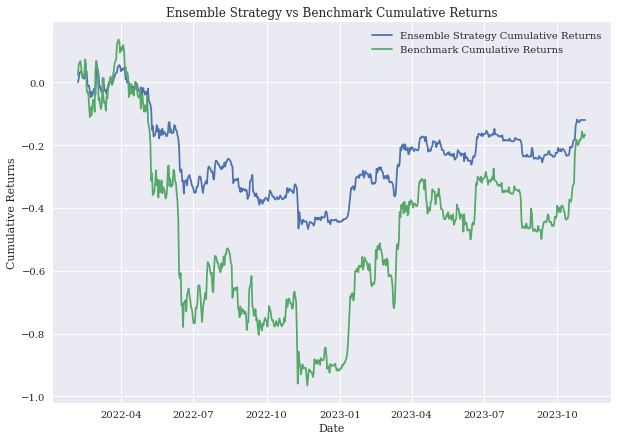

In [31]:
# Backtest the ensemble strategy
best_results = backtest_strategy_ensemble(valid_env, optimized_model)

# Calculate cumulative returns
strategy_cumulative_returns = best_results['Strategy_Returns'].cumsum()
benchmark_cumulative_returns = best_results['Returns'].cumsum()

# Plot the results
plt.figure(figsize=(10, 7))
plt.plot(strategy_cumulative_returns, label='Ensemble Strategy Cumulative Returns')
plt.plot(benchmark_cumulative_returns, label='Benchmark Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Ensemble Strategy vs Benchmark Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()